In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
tf.enable_eager_execution()

In [3]:
"""The problem statement mentions to use a pretrained network.
The originial paper on Neural Style Transfer utilises VGG19 which contains 5 convolution blocks
The paper also mentions that average pooling gives better results than max pooling """

MyModel = VGG19(include_top = False , weights = r'VGG19_WEIGHTS.h5',pooling = 'avg') 
#Not selecting the 3 fully connected layers at the end of the network

In [4]:
MyModel.trainable = False #In order to freeze the outputs generated by the convolution layers

In [5]:
MyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
#Function for getting the image and preprocessing it with the help of keras
def get_image(imagename):
    loaded = load_img(imagename)
    image = preprocess_input(img_to_array(loaded))
    image = np.expand_dims(image , axis = 0)
    return image 

In [7]:
japanese = get_image("japanese_garden.jpg")
picasso = get_image("picasso_selfportrait.jpg")

In [8]:
#To show the original images 
def reverse_process_image(image):
    #using the mean values in the official vgg implementation for normalizing 
    image[:,:,0] += 103.939
    image[:,:,1] += 116.779
    image[:,:,2] += 123.68
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8') #to limit values in the RGB spectrum , values lower than 0 become 0 and higher than 255 become 255 
    return image
    

In [9]:
def show(image):
    if(len(image.shape) == 4):
        image = np.squeeze(image , axis=0) #plt.imshow takes height,width and channels
    print(image.shape)
    image = reverse_process_image(image)
    
    plt.imshow(image)
    return

(498, 960, 3)


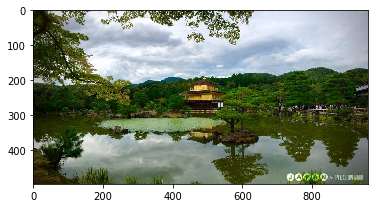

In [10]:
show(japanese)

(600, 468, 3)


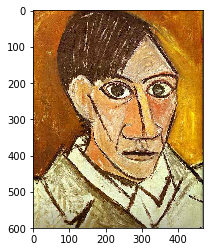

In [11]:
show(picasso)

In [12]:
#Selecting 5th block to get our broken down features
content_layer = 'block5_conv2'

#To visualise the image information that is encoded at
#different layers of the hierarchy we perform gradient descent
#on a white noise image to find another image that matches the feature responses of the original
#image

In [13]:
style_layers = [
    'block1_conv1',
    #block2_conv1',
    'block3_conv1',
    #block4_conv1',
    'block5_conv1',
]
#Authors of original paper make use of all the layers for Styling but due to limited GPU power 
#we are using alternating 3 layers

In [14]:
#Custom VGG model with only content layer and its output
cont_model = Model(
inputs = MyModel.input,
outputs = MyModel.get_layer(content_layer).output
)

In [15]:
#Custom VGG model with only style layers and their output
style_model = [Model(inputs = MyModel.input,
                     outputs = MyModel.get_layer(layer).output) for layer in style_layers]


In [16]:
#Finding out the mean squared error between the image that will be generated with the styles and the content image that we are applying the style on
def Content_Cost(content,generated):
    activation_content = cont_model(content)
    activation_generated = cont_model(generated)
    cost = tf.reduce_mean(tf.square(activation_content - activation_generated)) #Calculating the mean square error 
    return cost 

In [17]:
#Gram Matrices are used to represent the style of an image.
#In order to compute the style loss we will form gram matrices of the Style Image and the Generated Image
#The mean squared error between these two matrices is then reduced in our training loop
def gram_mat(X):
    num_channels = int(X.shape[-1])
    x = tf.reshape(X,[-1,num_channels])
    n = tf.shape(x)[0]
    G = tf.matmul(x,x,transpose_a=True)
    return G/tf.cast(n,tf.float32)

In [18]:
lambda_ = 1.0/len(style_model)
def Style_Cost(style,generated):
    style_cost = 0
    
    for styleModel in style_model:
        Style = styleModel(style) #Obtaining style representation of the Style Image
        Generated = styleModel(generated) #Obtaining style representation of the Generated Image
        G_Style = gram_mat(Style)
        G_Generated = gram_mat(Generated)
        cost = tf.reduce_mean(tf.square(G_Style-G_Generated))
        style_cost = style_cost + cost*lambda_
        
    return style_cost

In [19]:
def training(content_image , style_image , iter = 40 , alpha = 20. , beta = 10.):
    init_img= content_image #This is considered as the random image that is first taken 
    style_img = style_image
    content = tf.contrib.eager.Variable(init_img, dtype = tf.float32)
    #Use Adam to utilize tensorflow's gradient tape in out custom loop
    optimizer = tf.train.AdamOptimizer(learning_rate = 7.) 
    
    top_cost = 1e12 + 0.1
    top_img = None 
    for i in range(iter):
        with tf.GradientTape() as tape:  #tf.GradientTape A allows automatic differentiation i.e compute the derivative of the cost function with respect to input variables
            content_cost= Content_Cost(init_img,content)
            style_cost = Style_Cost(style_image ,content)
            Cost = alpha*content_cost + beta*style_cost #This represents the total cost 
            
            
        gradients = tape.gradient(Cost , content)
        optimizer.apply_gradients([(gradients , content)]) 
        
        if(Cost < top_cost):
            top_cost = Cost 
            top_img = content.numpy() #Convering tensor into numpy array
            
        
    return top_cost,top_img

In [20]:
top_cost , top_img = training(japanese , picasso)

(498, 960, 3)


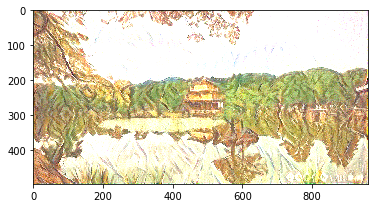

In [21]:
show(top_img)